## BLIP - Image Captioning

#### 1. Download model from Hugging Face

In [ ]:
import torch
import sys, os, shutil
from pathlib import Path
from transformers import AutoProcessor, BlipForConditionalGeneration
sys.path.append(str(Path('impl.ipynb').resolve().parents[3]))
from prep.params import SQLITE_PATH, BLIP_DIR

# Define the directory where models will be saved
TEMP_DIR = "./.blip_model"
# Define the specific BLIP model ID from Hugging Face
MODEL_ID = "Salesforce/blip-image-captioning-base" 

# Create the directory if it doesn't exist
if not os.path.exists(TEMP_DIR):
    os.makedirs(TEMP_DIR)

processor = AutoProcessor.from_pretrained(MODEL_ID)
model = BlipForConditionalGeneration.from_pretrained(MODEL_ID)
print("Model and processor loaded successfully.")

# Save the model and processor to the specified local directory
print(f"Saving model and processor to {"../../"+BLIP_DIR}...")
processor.save_pretrained("../../"+BLIP_DIR)
model.save_pretrained("../../"+BLIP_DIR)

# Clean up
shutil.rmtree(TEMP_DIR, ignore_errors=True)

#### 2. Load model from local folder

In [ ]:
import torch
import sys, os, shutil
from pathlib import Path
from transformers import AutoProcessor, BlipForConditionalGeneration
sys.path.append(str(Path('impl.ipynb').resolve().parents[3]))
from prep.params import SQLITE_PATH, BLIP_DIR

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
processor = AutoProcessor.from_pretrained("../../"+BLIP_DIR)
model = BlipForConditionalGeneration.from_pretrained("../../"+BLIP_DIR)
model.to(device)
model.eval()

#### 3. Captioning

In [ ]:
import requests
from PIL import Image

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    generated_ids = model.generate(**inputs, 
                                    max_length=50,
                                    do_sample=True,
                                    top_k=50,
                                    top_p=0.9,
                                    temperature=0.5,
                                    num_beams=1,            # Set to 1 for greedy or sampling. Use >1 for beam search (usually without do_sample=True).
                                    repetition_penalty=1.2, # Penalize repeating n-grams
                                   )

# Decode the generated IDs back into human-readable text
caption = processor.decode(generated_ids[0], skip_special_tokens=True)

# Print the generated caption
print("\nGenerated Caption: \n", caption)

# Display the image with the caption in notebook
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title(caption)
plt.show()

### Load from packed function

/Users/dna-tuananguyen/anaconda3/envs/apitcdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



Generated Caption: 
 two cats laying on a pink couch


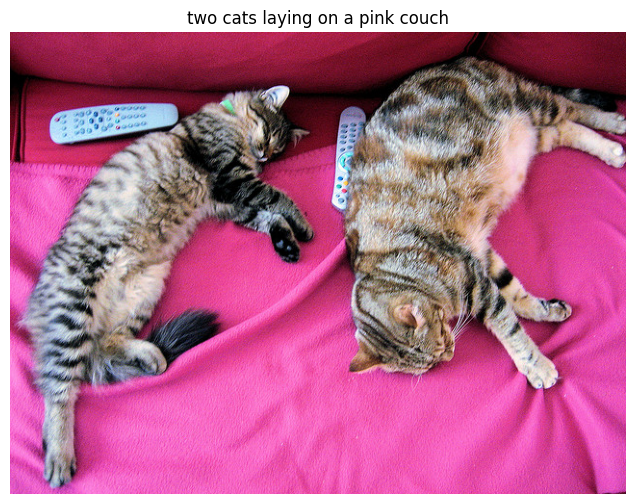

In [1]:
import requests, sys
from PIL import Image
from pathlib import Path
sys.path.append(str(Path('impl.ipynb').resolve().parents[3]))
from FrameCap import BlipCaptioner

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Image to base64
import base64
from io import BytesIO
def image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

image_base64 = image_to_base64(image)

Cap = BlipCaptioner()

caption = Cap.caption(image_base64)
print("\nGenerated Caption: \n", caption)

# Display the image with the caption in notebook
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title(caption)
plt.show()